# OrbitsDataset and OrbitsDataModule

> Orbits dataset.

In [ ]:
#| default_exp datasets.orbits

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import os, math
import numpy as np, pandas as pd

import torch, torch.nn as nn, pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
#| export
from dataclasses import dataclass, field, KW_ONLY

from beartype.typing import Optional, Tuple, Union, TypeAlias
from nptyping import NDArray, Float, Shape, Number as AnyNumber
from beartype import beartype

#| export
from littyping.core import Device

In [ ]:
#| export
from iza.utils import wrangle_kwargs_for_func

In [ ]:
#| export
from litds.types import (
    Number, Tensor,
    TrainValidTestSplit,
    DataFrame, IndexLike, SeriesLike, GroupKey,  
    XYArray, DistanceArray, LabelArray,     
    SequenceWithLength, SequencesWithLengths
)

from litds.abc.dfdm.base import set_dataset
from litds.utils import (random_split_dataframe)
from litds.time.base import (TimeDataset, TimeDataModule)

## Functions

In [ ]:
#| export
@beartype
def make_orbit(n_points: int, width: Number = 0.2) -> XYArray:
    '''Generates an orbit.

    Args:
        n_points: number of points in the orbit
        width: width of the orbit

    Returns:
        orbit: the orbit as a numpy array of shape (n_points, 2)
    '''
    angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    points = np.column_stack([np.cos(angles), width * np.sin(angles)])
    return points

@beartype
def rotate_orbit(orbit: XYArray, rotation_angle: float) -> XYArray:
    '''Rotates an orbit by a given angle.'''
    rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], 
                                [np.sin(rotation_angle),  np.cos(rotation_angle)]])
                                
    return np.matmul(orbit, rotation_matrix.T)

@beartype
def distance_from_origin(points: XYArray) -> DistanceArray:
    '''Calculates distance of points from the origin.'''
    return np.sqrt(np.sum(np.power(points, 2), axis=1))

@beartype
def categorize_distances(distances: DistanceArray, n_classes: int) -> LabelArray:
    '''Categorizes distances into n_classes classes.'''
    return pd.qcut(distances, q=n_classes, labels=False)

@beartype
def create_orbits_dataset(
    n_orbits: int, n_points: int, width: Number = 0.2, 
    noise_level: float = 0., label_by_distance: bool=True, n_classes: Optional[int] = 5
) -> Tuple[XYArray, LabelArray]:
    '''Generates a dataset of orbits.'''
    
    data = np.empty((0, 2))
    labels = np.empty(0, dtype=int)

    if n_classes is None:
        n_classes = n_orbits

    for i in range(n_orbits):
        orbit: XYArray = make_orbit(n_points, width)
        orbit = rotate_orbit(orbit, (2 * np.pi / n_orbits) * i)
        
        # add Gaussian noise
        orbit += np.random.normal(0, noise_level, np.array(orbit).shape)
        
        data: XYArray = np.vstack((data, orbit))



        if label_by_distance:            
            distances = distance_from_origin(orbit)            
            labels: LabelArray = np.hstack((labels, categorize_distances(distances, n_classes)))
        else:
            labels: LabelArray = np.hstack((labels, np.full(n_points, i)))
            
    return data, labels

@beartype
def create_orbits_dataframe(
    n_orbits: int = 5, n_points: int = 400, width: Number = 0.2, 
    noise_level: float = 0., label_by_distance: bool=True, n_classes: Optional[int] = 5,
    label_key: str = 'label', use_index: bool = True
) -> pd.DataFrame:    
    x, y = create_orbits_dataset(
        n_orbits, n_points, width, noise_level, label_by_distance, n_classes
    )
    df = pd.DataFrame(x, columns=['x', 'y'], index=pd.Series(y, name=label_key))
    if not use_index:
        df.reset_index(inplace=True)
    return df

In [ ]:
df = create_orbits_dataframe(5, 400, .25, noise_level=.025, label_by_distance=True, n_classes=5)
df.head()

,x,y
label,,
4,0.986363,0.024106
4,0.995865,-0.015601
4,1.022529,-0.001975
4,1.002284,0.012532
4,0.978433,0.003777


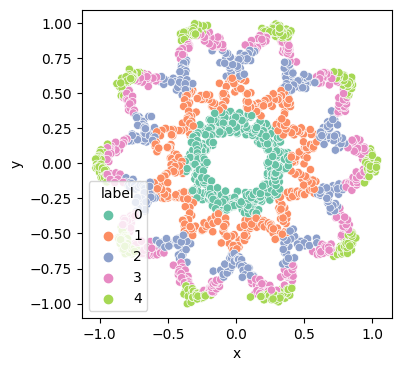

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='Set2')
plt.show()

## Dataset

In [ ]:
#| export
@dataclass
class OrbitsDataset(TimeDataset):
    n_orbits: int = 5
    n_points: int = 400
    width: Number = 0.2
    noise_level: float = 0.025
    label_by_distance: bool = True
    n_classes: Optional[int] = 5    

    _: KW_ONLY = field(default=None, init=False)
    include_time: Optional[bool] = False
    device: Optional[Device] = None

    def __init__(self, *args, **kwargs) -> None:
        df = kwargs.pop('df', None)
        if df is None:
            params = dict(
                n_orbits=self.n_orbits, n_points=self.n_points, 
                width=self.width, noise_level=self.noise_level, 
                label_by_distance=self.label_by_distance, 
                n_classes=self.n_classes, label_key=self.time_key, use_index=False
            )        
            params = wrangle_kwargs_for_func(create_orbits_dataframe, params, **kwargs)
            df = create_orbits_dataframe(**params)
        self.df = df
        super().__init__(df=df)

    def __post_init__(self):
        super().__post_init__()

    def plot(self, figsize=(4, 4), palette='magma'):
        plt.figure(figsize=figsize)
        sns.scatterplot(data=self.df, x='x', y='y', hue=self.time_key, palette=palette)
        plt.show()

In [ ]:
#| eval: False
dd = OrbitsDataset()
dd.getone()

(tensor([[-0.0875, -0.1872],
         [ 0.2494, -0.3807],
         [-0.4403, -0.4955],
         [ 0.7146,  0.4166],
         [ 0.3441, -0.8967]]),
 tensor([0., 1., 2., 3., 4.]))

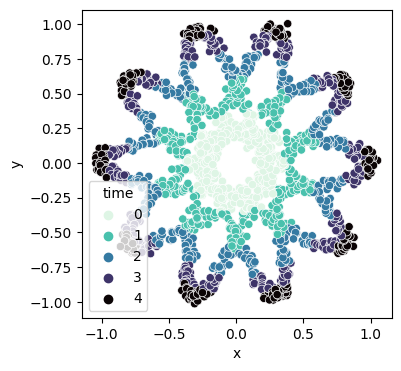

In [ ]:
#| eval: False
dd.plot(palette='mako_r')

## DataModule

In [ ]:
#| export
@dataclass
@set_dataset(OrbitsDataset)
class OrbitsDataModule(TimeDataModule):
    n_orbits: int = 5
    n_points: int = 400 
    width: Number = 0.2
    noise_level: float = 0.025
    label_by_distance: bool = True 
    n_classes:  Optional[int] = 5

    perc_train: float = 0.7
    perc_valid: float = 0.1
    perc_test:  float = 0.2

    _: KW_ONLY = field(default=None, init=False)
    include_time: Optional[bool] = False
    device: Optional[Device] = None
    
    def prepare_data(self, *args, **kwargs):
        df = create_orbits_dataframe(
            self.n_orbits, self.n_points, self.width,
            self.noise_level, self.label_by_distance, self.n_classes,
            label_key=self.time_key, use_index = False
        )
        self.df = df

        self.splits = TrainValidTestSplit(self.perc_train, self.perc_valid, self.perc_test)
        return self
    
    def setup(self, stage:Optional[str]=None):
        self.prepare_data()

        df_tmp = self.df
        if not self.include_time:
            df_tmp = df_tmp.drop(columns=self.time_key, errors='ignore')
        
        idxs_train, idxs_valid, idxs_test = random_split_dataframe(
            df_tmp, self.splits, as_dataframes=False
        )

        self.idxs_train = idxs_train
        self.idxs_valid = idxs_valid
        self.idxs_test = idxs_test
        
        if stage == 'fit':
            pass
        
        if stage == 'test':
            pass
        
        if stage == 'predict':
            pass

    def collate_fn(self, batch):
        seqs, lens = zip(*batch)
        seqs = torch.stack(seqs)
        lens = torch.stack(lens)
        return seqs, lens

    def train_dataloader(self):
        ds = self.make_dataset(df=self.df.iloc[self.idxs_train])
        self.train_ds = ds
        return DataLoader(ds, batch_size=self.batch_size, collate_fn=self.collate_fn)
    
    def val_dataloader(self):
        ds = self.make_dataset(df=self.df.iloc[self.idxs_valid])
        self.valid_ds = ds
        return DataLoader(ds, batch_size=self.batch_size, collate_fn=self.collate_fn)
    
    def test_dataloader(self):
        ds = self.make_dataset(df=self.df.iloc[self.idxs_test])
        self.test_ds = ds
        return DataLoader(ds, batch_size=self.batch_size, collate_fn=self.collate_fn)    

### Example

In [ ]:
#| eval: False
ddm = OrbitsDataModule()

In [ ]:
#| eval: False
ddm.prepare_data()

OrbitsDataModule(n_orbits=5, n_points=400, width=0.2, noise_level=0.025, label_by_distance=True, n_classes=5, perc_train=0.7, perc_valid=0.1, perc_test=0.2, include_time=False, device=None)

In [ ]:
#| eval: False
ddm.setup()

In [ ]:
#| eval: False
train_dl = ddm.train_dataloader()

In [ ]:
#| eval: False
for batch in train_dl:
    break
batch[0].shape, batch[1].shape

(torch.Size([64, 5, 2]), torch.Size([64, 5]))

In [ ]:
#| eval: False
len(ddm.idxs_train), len(ddm.idxs_valid), len(ddm.idxs_test)

(1400, 200, 400)

In [ ]:
#| eval: False
ddm.train_ds.df.shape

(2000, 3)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()